In [1]:
import pickle
# Importing libraries
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
from seaborn import PairGrid, kdeplot, jointplot
import theano.tensor as tt

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
df = pd.read_pickle('./pickleJar/df_log.pkl')

In [3]:
df.head().T

,0,1,2,3,4
id,4045,4056,4057,5949,5950
datetime,1998-08-29 17:55:00,1998-09-02 15:52:00,1998-09-02 18:10:00,1997-10-12 23:38:00,1997-10-13 18:33:00
lat,60.587,60.674,60.604,59.118,58.792
lon,-146.409,-147.682,-147.205,-148.677,-148.493
etopo2_l,1.91381,1.14613,2.02938,2.15534,2.45637
oisst,13.04,11.74,11.74,9.71,9.84
sal_l,NaN,NaN,NaN,NaN,NaN
rrs411_l,-2.48181,-2.69759,-2.57346,-2.74698,-2.85684
rrs443_l,-2.39369,-2.57914,-2.48391,-2.66945,-2.77425
rrs489_l,-2.32961,-2.44558,-2.39021,-2.56902,-2.6778


In [11]:
d_ = df[['provCat', 'mxBlCat', 'biomCat', 'MxBl-Gr',
         'oisst', 'etopo2_l', 'chl']].dropna()
d_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4126 entries, 0 to 4458
Data columns (total 7 columns):
provCat     4126 non-null int8
mxBlCat     4126 non-null int8
biomCat     4126 non-null int8
MxBl-Gr     4126 non-null float64
oisst       4126 non-null float64
etopo2_l    4126 non-null float64
chl         4126 non-null float64
dtypes: float64(4), int8(3)
memory usage: 173.3 KB


In [56]:
df.loc[df.biomCat==3, 'biome'].head(1)

3634    Westerlies
Name: biome, dtype: object

In [12]:
n_provinces = d_.provCat.unique().size
n_blues = d_.mxBlCat.unique().size
n_biomes = d_.biomCat.unique().size
provIdx = d_.provCat.values
blueIdx = d_.mxBlCat.values
biomeIdx = d_.biomCat.values
log_band_ratio = d_['MxBl-Gr'].values
log_depth = d_['etopo2_l'].values
sst = d_['oisst'].values
predicted = d_['chl'].values

In [62]:
with pm.Model() as mdl_bl:
    # hyperpriors
    mu_a = pm.Normal('mu_a', 0, sd=100)
    sigma_a = pm.HalfCauchy('sigma_a', 2.5)
    mu_b = pm.Normal('mu_b', 0, sd=100)
    sigma_b = pm.HalfCauchy('sigma_b', 2.5)
    #priors
    
    a_blue = pm.Normal('a_blue', mu=mu_a, sd=sigma_a, shape=n_blues)
    b_blue = pm.Normal('b_blue', mu=mu_b, sd=sigma_b, shape=n_blues)
    
    #forward model & model error
    mu_ = a_blue[blueIdx] + b_blue[blueIdx] * log_band_ratio
    eps = pm.HalfCauchy('eps', beta=5)
    
    #likelihood
    log_chl = pm.Lognormal('log_chl', mu=mu_, sd=eps, observed=predicted)
    trace_bl = pm.sample(5000, tune=5000, nuts_kwargs=dict(target_accept=0.9))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps_log__, b_blue, a_blue, sigma_b_log__, mu_b, sigma_a_log__, mu_a]
 10%|▉         | 960/10000 [00:09<01:34, 96.02it/s]/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
100%|██████████| 10000/10000 [00:57<00:00, 173.84it/s]
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


In [63]:
pm.summary(trace_bl)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu_a,0.811941,0.633525,0.015305,-0.177445,1.875187,1529.424827,1.001070
mu_b,-4.896512,2.056108,0.025497,-8.585272,-0.788960,6241.300745,1.000000
a_blue__0,1.011114,0.050006,0.000470,0.914594,1.108185,10792.484128,1.000110
a_blue__1,0.545185,0.035826,0.000351,0.474952,0.615289,12328.717916,1.000154
a_blue__2,0.878159,0.024942,0.000185,0.829989,0.927228,16423.860624,0.999918
b_blue__0,-4.470440,0.082528,0.000752,-4.632930,-4.312298,10999.857034,1.000107
b_blue__1,-3.279938,0.152813,0.001511,-3.581615,-2.982450,11976.295847,1.000072
b_blue__2,-7.024330,0.189209,0.001462,-7.400119,-6.657854,15507.128302,0.999967
sigma_a,0.670785,0.810217,0.016216,0.088748,1.938500,2315.508997,1.000459
sigma_b,2.853768,2.270875,0.029747,0.729668,6.406125,4902.962776,1.000008


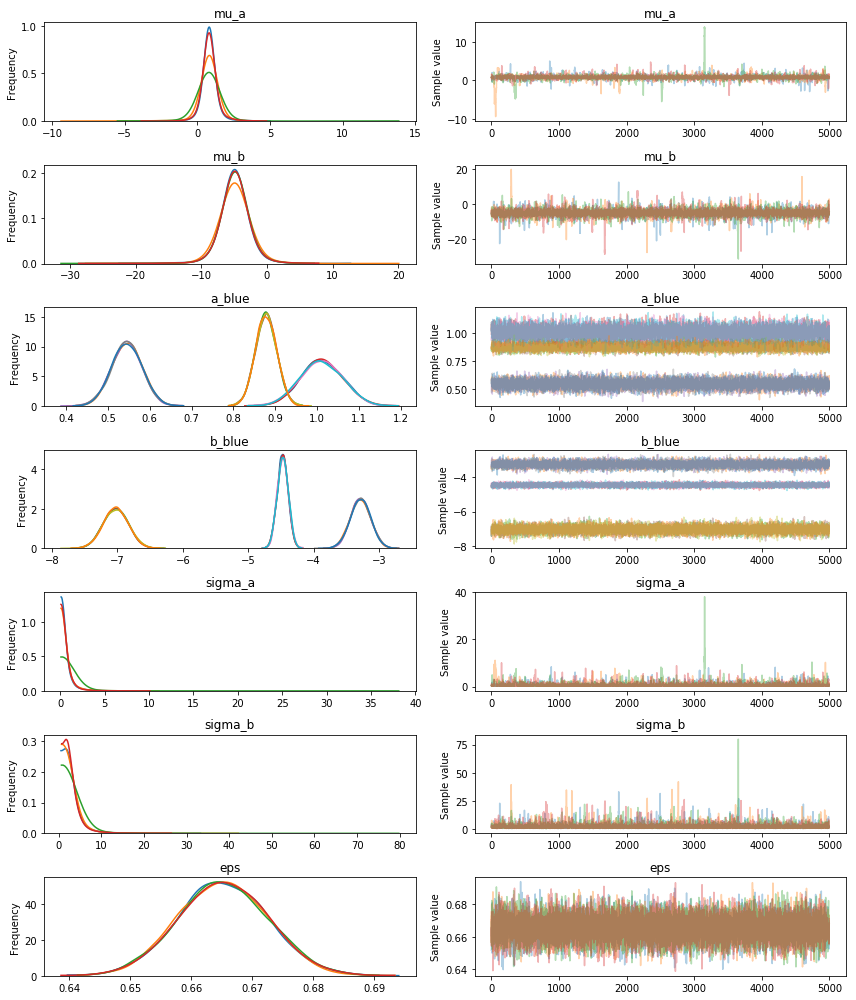

In [64]:
pm.traceplot(trace_bl);

In [ ]:
# ppc on max-blue-band clustering


Biome-clustered model

In [47]:
with pm.Model() as mdl_biom:
    # hyperpriors
    mu_a = pm.Normal('mu_a', 0, sd=100)
    sigma_a = pm.HalfCauchy('sigma_a', 2.5)
    mu_b = pm.Normal('mu_b', 0, sd=100)
    sigma_b = pm.HalfCauchy('sigma_b', 2.5)
    #priors
    
    a_biome = pm.Normal('a_biome', mu=mu_a, sd=sigma_a, shape=n_biomes)
    b_biome = pm.Normal('b_biome', mu=mu_b, sd=sigma_b, shape=n_biomes)
    
    #forward model & model error
    mu_ = a_biome[biomeIdx] + b_biome[biomeIdx] * log_band_ratio
    eps = pm.HalfCauchy('eps', beta=5)
    
    #likelihood
    log_chl = pm.Lognormal('log_chl', mu=mu_, sd=eps, observed=predicted)
    trace_biom = pm.sample(5000, tune=5000, nuts_kwargs=dict(target_accept=0.9))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps_log__, b_biome, a_biome, sigma_b_log__, mu_b, sigma_a_log__, mu_a]
  7%|▋         | 672/10000 [00:09<02:17, 67.69it/s]/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
100%|██████████| 10000/10000 [00:48<00:00, 205.59it/s]


In [48]:
pm.summary(trace_biom)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu_a,0.908932,0.371343,0.004229,0.189849,1.667597,8325.902575,1.000274
mu_b,-4.558777,0.472370,0.005897,-5.542308,-3.686193,5248.716856,1.000412
a_biome__0,0.848760,0.018451,0.000117,0.813333,0.885475,21456.420033,1.000054
a_biome__1,1.419382,0.027839,0.000179,1.363123,1.472732,17638.392657,0.999928
a_biome__2,0.833458,0.037248,0.000275,0.762579,0.908309,17755.141286,0.999927
a_biome__3,0.523388,0.036285,0.000267,0.451886,0.594479,17114.657401,0.999921
b_biome__0,-5.096939,0.062536,0.000378,-5.219521,-4.974176,20760.568869,1.000131
b_biome__1,-4.693897,0.078783,0.000508,-4.845471,-4.537195,18127.364491,0.999941
b_biome__2,-4.343113,0.064624,0.000475,-4.467430,-4.211836,17929.286344,0.999948
b_biome__3,-4.039462,0.067775,0.000485,-4.172305,-3.906337,17678.304575,0.999931


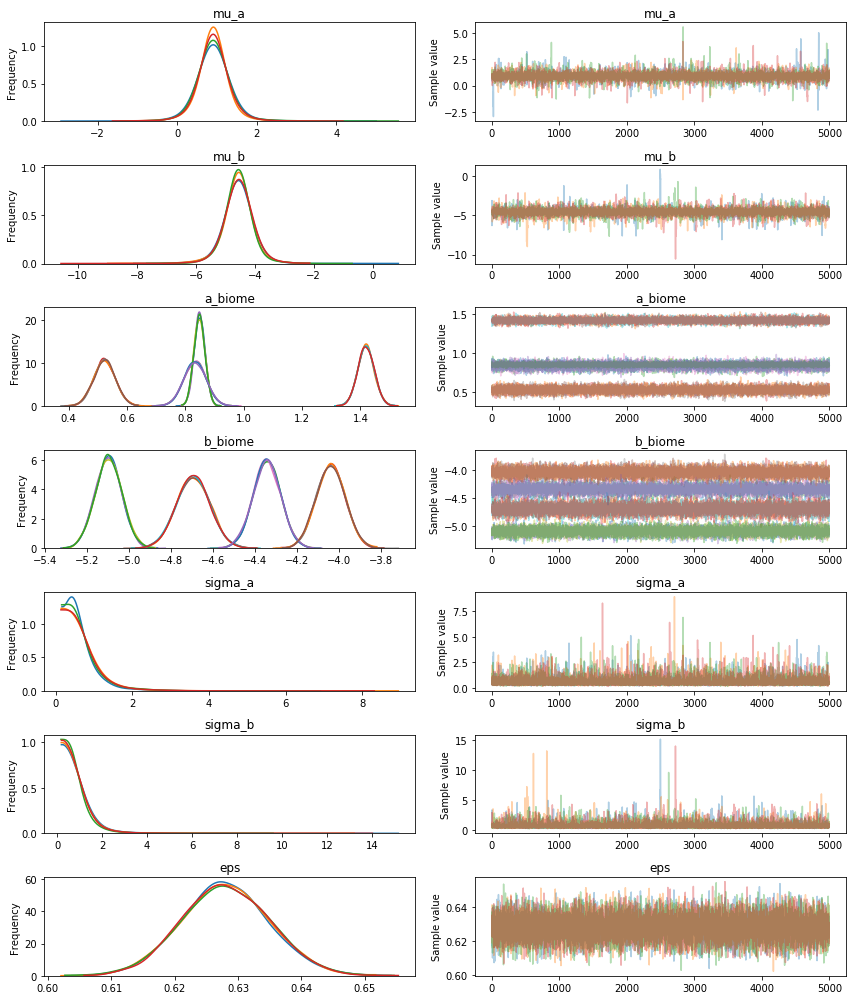

In [49]:
pm.traceplot(trace_biom);

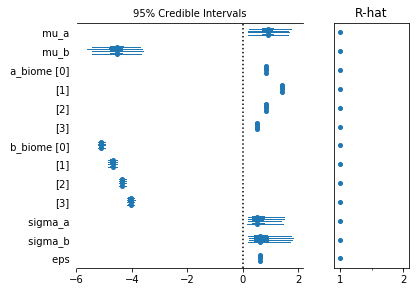

In [51]:
pm.forestplot(trace_biom);

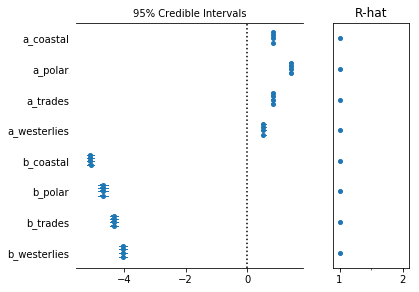

In [61]:
pm.forestplot(trace_biom, varnames=['a_biome', 'b_biome'], 
              ylabels=['a_coastal', 'a_polar', 'a_trades', 'a_westerlies',
                      'b_coastal', 'b_polar', 'b_trades', 'b_westerlies'])

Province-clustered model

In [ ]:
with pm.Model() as mdl_prov:
    # hyperpriors
    mu_a = pm.Normal('mu_a', 0, sd=100)
    sigma_a = pm.HalfCauchy('sigma_a', 2.5)
    mu_b = pm.Normal('mu_b', 0, sd=100)
    sigma_b = pm.HalfCauchy('sigma_b', 2.5)
    #priors
    
    a_prov = pm.Normal('a_prov', mu=mu_a, sd=sigma_a, shape=n_provinces)
    b_prov = pm.Normal('b_prov', mu=mu_b, sd=sigma_b, shape=n_provinces)
    
    #forward model & model error
    mu_ = a_prov[provIdx] + b_prov[provIdx] * log_band_ratio
    eps = pm.HalfCauchy('eps', beta=5)
    
    #likelihood
    log_chl = pm.Lognormal('log_chl', mu=mu_, sd=eps, observed=predicted)
    trace_prov = pm.sample(5000, tune=5000, nuts_kwargs=dict(target_accept=0.9))